# Unlocking the musicality of Billboard Hot 100 songs

In [1]:
# Set toggle on/off of raw codes.
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Set alignment of plots to center.
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import base64
import json
from urllib.parse import urlencode
from bs4 import BeautifulSoup as soup
import urllib.request as uReq
import requests
import datetime
import time
import pandas as pd
import numpy as np
import sqlite3
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import random
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# 1. Executive Summary

The music industry in the US raked in an estimated revenue of USD 11 billion in 2019. Throughout the years, this revenue keeps on growing year by year. Moreover, new artists pop up each year taking a chance of making a mark in the industry. To do this, many artists, aim for that privileged spot in the US Billboard Hot 100. This made us wonder, "What does it take to break in to the US Billboard Hot 100 list?"

Specifically, we aim to answer the following questions:
1. What are the big names and songs in the US music scene in 2019?
2. What are the observable patterns of songs in the 2019 US Billboard Hot 100 list in terms of there audio features?

# 2. Introduction

The Billboard Hot 100, released weekly, is the music industry standard record chart in the United States for songs. Chart rankings are based on sales, radio play, and online streaming in the United States. The weekly Billboard Hot 100 charts for 2019 was scraped through  BeautifulSoup libraries. The songs included in the US Billboard Hot 100 songs for 2019 were then prepared. The corresponding audio features were pulled from Spotify database through Spotify API. The figure below describes how the data were obtained from both Billboard's official website and from Spotify API.

![image](data_process.PNG)

Of the 15 columns returned by the Spotify API call, only these columns were used in the analysis.



|Field Names                               | Data  Type| Description
|:-|:-|:-|
|Song ID                              |Alphanumeric | The base-62 track identifier that can be found at the end of the Spotify URI for a track resource.|
|Key                                  |Integer | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation.  |
|Acousticness                         |Float | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
|Danceability                         |Float | Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. |
|Energy                               |Float | Measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. |
|Instrumentalness      |Float| Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.  |
|Liveness      |Float| Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.  |
|Loudness      |Float| The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. |
|Speechiness      |Float| Detects the presence of spoken words in a track.   |
|Valence      |Float| Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).  |
|Tempo      |Float| The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.  |



</div>

<center><i><b>Table 2:</b> Spotify Data and Audio Features </i></center>


More information of audio features can be found at the Spotify documentation [Spotify Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/).



# 3. Data Processing

## 3.1. Data Scraping

In this section, the we will elaborate how data were scraped from the [US Billboard's offical page](https://www.billboard.com/) and using Spotify's API.

### 3.1.1. Get weekly chart from Billboard.com for 2019

A total of 5,200 records for the 52 weeks of 2019 were scraped from the official website of the US Billboard. Each record contains `Date`, `Chart_Week`, `Rank`, `Song`, `Artist`, and `Weeks on Chart`. For this process, we did the following steps sequentially:
1. Generate the start and end dates (should be a Saturday) of the duration of weekly Hot 100 charts to scrape.
2. Using the generated dates, scrape the necessary information. Store these information in a pandas DataFrame.
3. Create SQLite database `billboard.db` that will store all the information in the DataFrame created.

In [4]:
def generate_date(start_date, stop_date):
    """Return list of start and end dates of weekly charts to scrape."""
    
    date_list = [start_date.strftime('%Y-%m-%d')]
    while start_date < stop_date:        
        start_date += datetime.timedelta(days=7)
        date_list.append(start_date.strftime('%Y-%m-%d'))
    return date_list


def get_weeklychart(billboard_url, date):
    """Return as DataFrame a weekly top 100 chart from Billboard.com."""
    
    weekly_bb100 = []
    r = requests.get(f'{billboard_url}/{date}').text
    bb100 = soup(r,'html.parser')
    chart_date = bb100.body.main.div.get("data-chart-date")
    list100 = bb100.body.main.div.select("li.chart-list__element")

    for song in list100:
        chart_week = datetime.datetime.strptime(chart_date,
                                                '%Y-%m-%d').strftime("%V")
        rank = song.select_one("span.chart-element__rank__number").text
        song_title = song.select_one("span.chart-element"
                                     "__information__song").text
        artist_name = song.select_one("span.chart-element__"
                                      "information__artist").text
        weeksonchart = song.select_one("span.chart-element__"
                                       "information__delta__"
                                       "text.text--week").text.split(" ")[0]
        weekly_bb100.append([chart_date, chart_week, rank, song_title,
                             artist_name, weeksonchart])
        
    df_bb100 = pd.DataFrame(weekly_bb100, 
    columns = ['Date', 'Chart_Week', 'Rank', 'Song', 'Artist', 
               'Weeks on Chart'])  
    return df_bb100

def get_all(start_date, stop_date):
    """Save to SQLite database all weekly charts from Billboard.com."""
    
    billboard_url = 'https://www.billboard.com/charts/hot-100'
#     proxies = {'https':'http://206.189.157.23',
#                'http':'https://206.189.157.23'}

    date_covered = generate_date(start_date, stop_date)
    df_all = pd.DataFrame()
    for date in date_covered:
        #df_weeklychart = get_weeklychart(billboard_url, date, proxies)
        df_weeklychart = get_weeklychart(billboard_url, date)
        df_all = df_all.append(df_weeklychart,ignore_index=True)

    #Write in SQLite db
    conn = sqlite3.connect('billboard.db')
    df_all.to_sql('billboard', con=conn, if_exists="append", index=False)

In [5]:
# # Set start date for the charts to scrape -- Choose Saturday date
# start_date = datetime.date(2019,1,5)
# stop_date = datetime.date(2019,12,28)

# # Scrape from Billboard.com and save to SQLite database
# get_all(start_date, stop_date)

### 3.1.2. Collect audio features from Spotify API
To collect the audio features of each song in `billboard.db` from Spotify API, the following steps are performed sequentially:

__1. Pull data from `billboard.db` and get information need to get audio features using Spotify API.__

In [6]:
conn = sqlite3.connect('billboard.db')
df = pd.read_sql('''SELECT * from billboard''', conn)
df.head()

Date Chart_Week Rank                                           Song  \
0  2019-01-05         01    1                                  Thank U, Next   
1  2019-01-05         01    2                                     Without Me   
2  2019-01-05         01    3                All I Want For Christmas Is You   
3  2019-01-05         01    4                                     Sicko Mode   
4  2019-01-05         01    5  Sunflower (Spider-Man: Into The Spider-Verse)   

                   Artist Weeks on Chart  
0           Ariana Grande              8  
1                  Halsey             12  
2            Mariah Carey             30  
3            Travis Scott             21  
4  Post Malone & Swae Lee             10

__2. To get the audio features of a song from Spotify API, the `song id` of the song is necessary to retrieve the needed data. Then, to collect the `song id` from the Spotify API, the key `<song title> <artist>` is needed. Hence, we processed the key of each song in our database.__

In [7]:
# # Get only main artist of each song.
# df['query_artist'] = df['Artist'].apply(lambda x:" ".join(x.split(" ")[:2]))

# # Combine artist name and song to be used in merging with Spotify data.
# df['key'] = df['Song'] + " " + df['query_artist']
# df['key'] = [re.sub(r'\b[fF]eaturing\b|\b[Xx]\b', '', str(x)) 
#                          for x in df['key']]

__3. The `"<song title> <artist>"` keys were used to get the corresponding `song_id` of every song in `database.db`.__

In [8]:
# client_id = '461f3c58790c448c83a96dc76984eb76'
# client_secret = '370c74af03d94c1dbd1a1050e41aeb41'
# token_url = 'https://accounts.spotify.com/api/token'

In [9]:
# from oauthlib.oauth2 import BackendApplicationClient
# from requests_oauthlib import OAuth2Session

# client_id = '461f3c58790c448c83a96dc76984eb76'
# client_secret = '370c74af03d94c1dbd1a1050e41aeb41'
# token_url = 'https://accounts.spotify.com/api/token'

# client_creds = f'{client_id}:{client_secret}'
# client_creds_64 = base64.b64encode(client_creds.encode())

# method = "POST"
# token_data = {
#     "grant_type":"client_credentials"
# }
# token_header = {
#     "Authorization":f"Basic {client_creds_64.decode()}"
# }

# client = BackendApplicationClient(client_id=client_id)
# oauth = OAuth2Session(client=client)

# def refresh_token():
#     """Get token for authorization."""
    
#     token = oauth.fetch_token(
#         token_url='https://accounts.spotify.com/api/token', 
#         client_id=client_id,
#         client_secret=client_secret)
#     return token

# def track_id(search):
#     """Return song_id of song in Spotify."""
    
#     refresh_token()
#     a = oauth.get(
#         'https://api.spotify.com/v1/search',
#         params=dict(
#             q=search,
#             type='track')).json()
#     try:
#         song_id = a['tracks']['items'][0]['id']
#     except:
#         song_id = None
#     return song_id

In [10]:
# refresh_token()

__4. Using the `song id` collected, the audio features were collected from the Spotify API.__

In [11]:
# df['song_id'] = df['key'].apply(track_id)
# df

__5. Upon checking if each song has their correspnding audio features, we found one song that has none due to some sensored letters of the the song title. So, we inputted the exact song title and took its audio features.__

In [12]:
# df.iloc[996, -1] = track_id("Same Yung Nigga Gunna")

__6. All songs and their corresponding audio features were combined in a pandas DataFrame and saved as a csv file (songs_billboard_spotify.csv).__

In [13]:
# features = []
# for s_id in df['song_id'].values:
#     refresh_token()
#     a = 'https://api.spotify.com/v1/audio-features/' + s_id
#     af = oauth.get(a).json()
#     features.append(af)

In [14]:
# a_features = pd.DataFrame(features).iloc[:,:11]
# df_songs = pd.concat([df.reset_index(), a_features], axis=1)
# df_songs.to_csv("songs_billboard_spotify.csv")

### 3.2. Retrieve scraped song list in `songs_billboard_spotify.csv` for exploratory data analysis.

In [15]:
df_songs = pd.read_csv("songs_billboard_spotify.csv", 
                       usecols = [2, 3, 4, 5, 6, 7, 11, 12, 13, 14,
                                  16, 17, 18, 19, 20, 21])
df_songs = df_songs.rename(columns={'key.1' : 'key'})
df_songs.head()

Date  Chart_Week  Rank  \
0  2019-01-05           1     1   
1  2019-01-05           1     2   
2  2019-01-05           1     3   
3  2019-01-05           1     4   
4  2019-01-05           1     5   

                                            Song                  Artist  \
0                                  Thank U, Next           Ariana Grande   
1                                     Without Me                  Halsey   
2                All I Want For Christmas Is You            Mariah Carey   
3                                     Sicko Mode            Travis Scott   
4  Sunflower (Spider-Man: Into The Spider-Verse)  Post Malone & Swae Lee   

   Weeks on Chart  danceability  energy  key  loudness  speechiness  \
0               8         0.717   0.653    1    -5.634       0.0658   
1              12         0.752   0.488    6    -7.050       0.0705   
2              30         0.695   0.652   11    -7.828       0.0751   
3              21         0.834   0.730    8    -3.714       0.2220   
4              10         0.760   0.479    2    -5.574       0.0466   

   acousticness  instrumentalness  liveness  valence    tempo  
0      0.229000          0.000000    0.1010    0.412  106.966  
1      0.297000          0.000009    0.0936    0.533  136.041  
2      0.000441          0.000006    0.0667    0.744  128.024  
3      0.005130          0.000000    0.1240    0.446  155.008  
4      0.556000          0.000000    0.0703    0.913   89.911

# 4. Exploratory Data Analysis 

In this section, we will surface some insights that we got from the weekly Hot 100 chart of the US Billboard in 2019. 

## 4.1. "Big Words" and "Big Names"

The following word-cloud provides a quick overview of what the hit songs and big names are in 2019.

In [16]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    """Set theme color of wordcloud."""
    
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def word_cloud(comment_words, comment_words1): 
    """Return wordcloud of string as axes."""
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 15), dpi=250, facecolor=None) 
    
    stopwords = set(STOPWORDS)   
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
    
    ax[0].imshow(wordcloud.recolor(color_func=grey_color_func, 
                                   random_state=3),
               interpolation="bilinear")
    ax[0].axis("off")
    ax[0].set_title("Songs of 2019", fontsize=25)
    
    stopwords1 = set(STOPWORDS)   
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',
                stopwords = stopwords1, 
                min_font_size = 10).generate(comment_words1)
    
    ax[1].imshow(wordcloud.recolor(color_func=grey_color_func, 
                                   random_state=3),
               interpolation="bilinear")
    ax[1].axis("off") 
    ax[1].set_title("Artists of 2019", fontsize=25)
    
    return ax

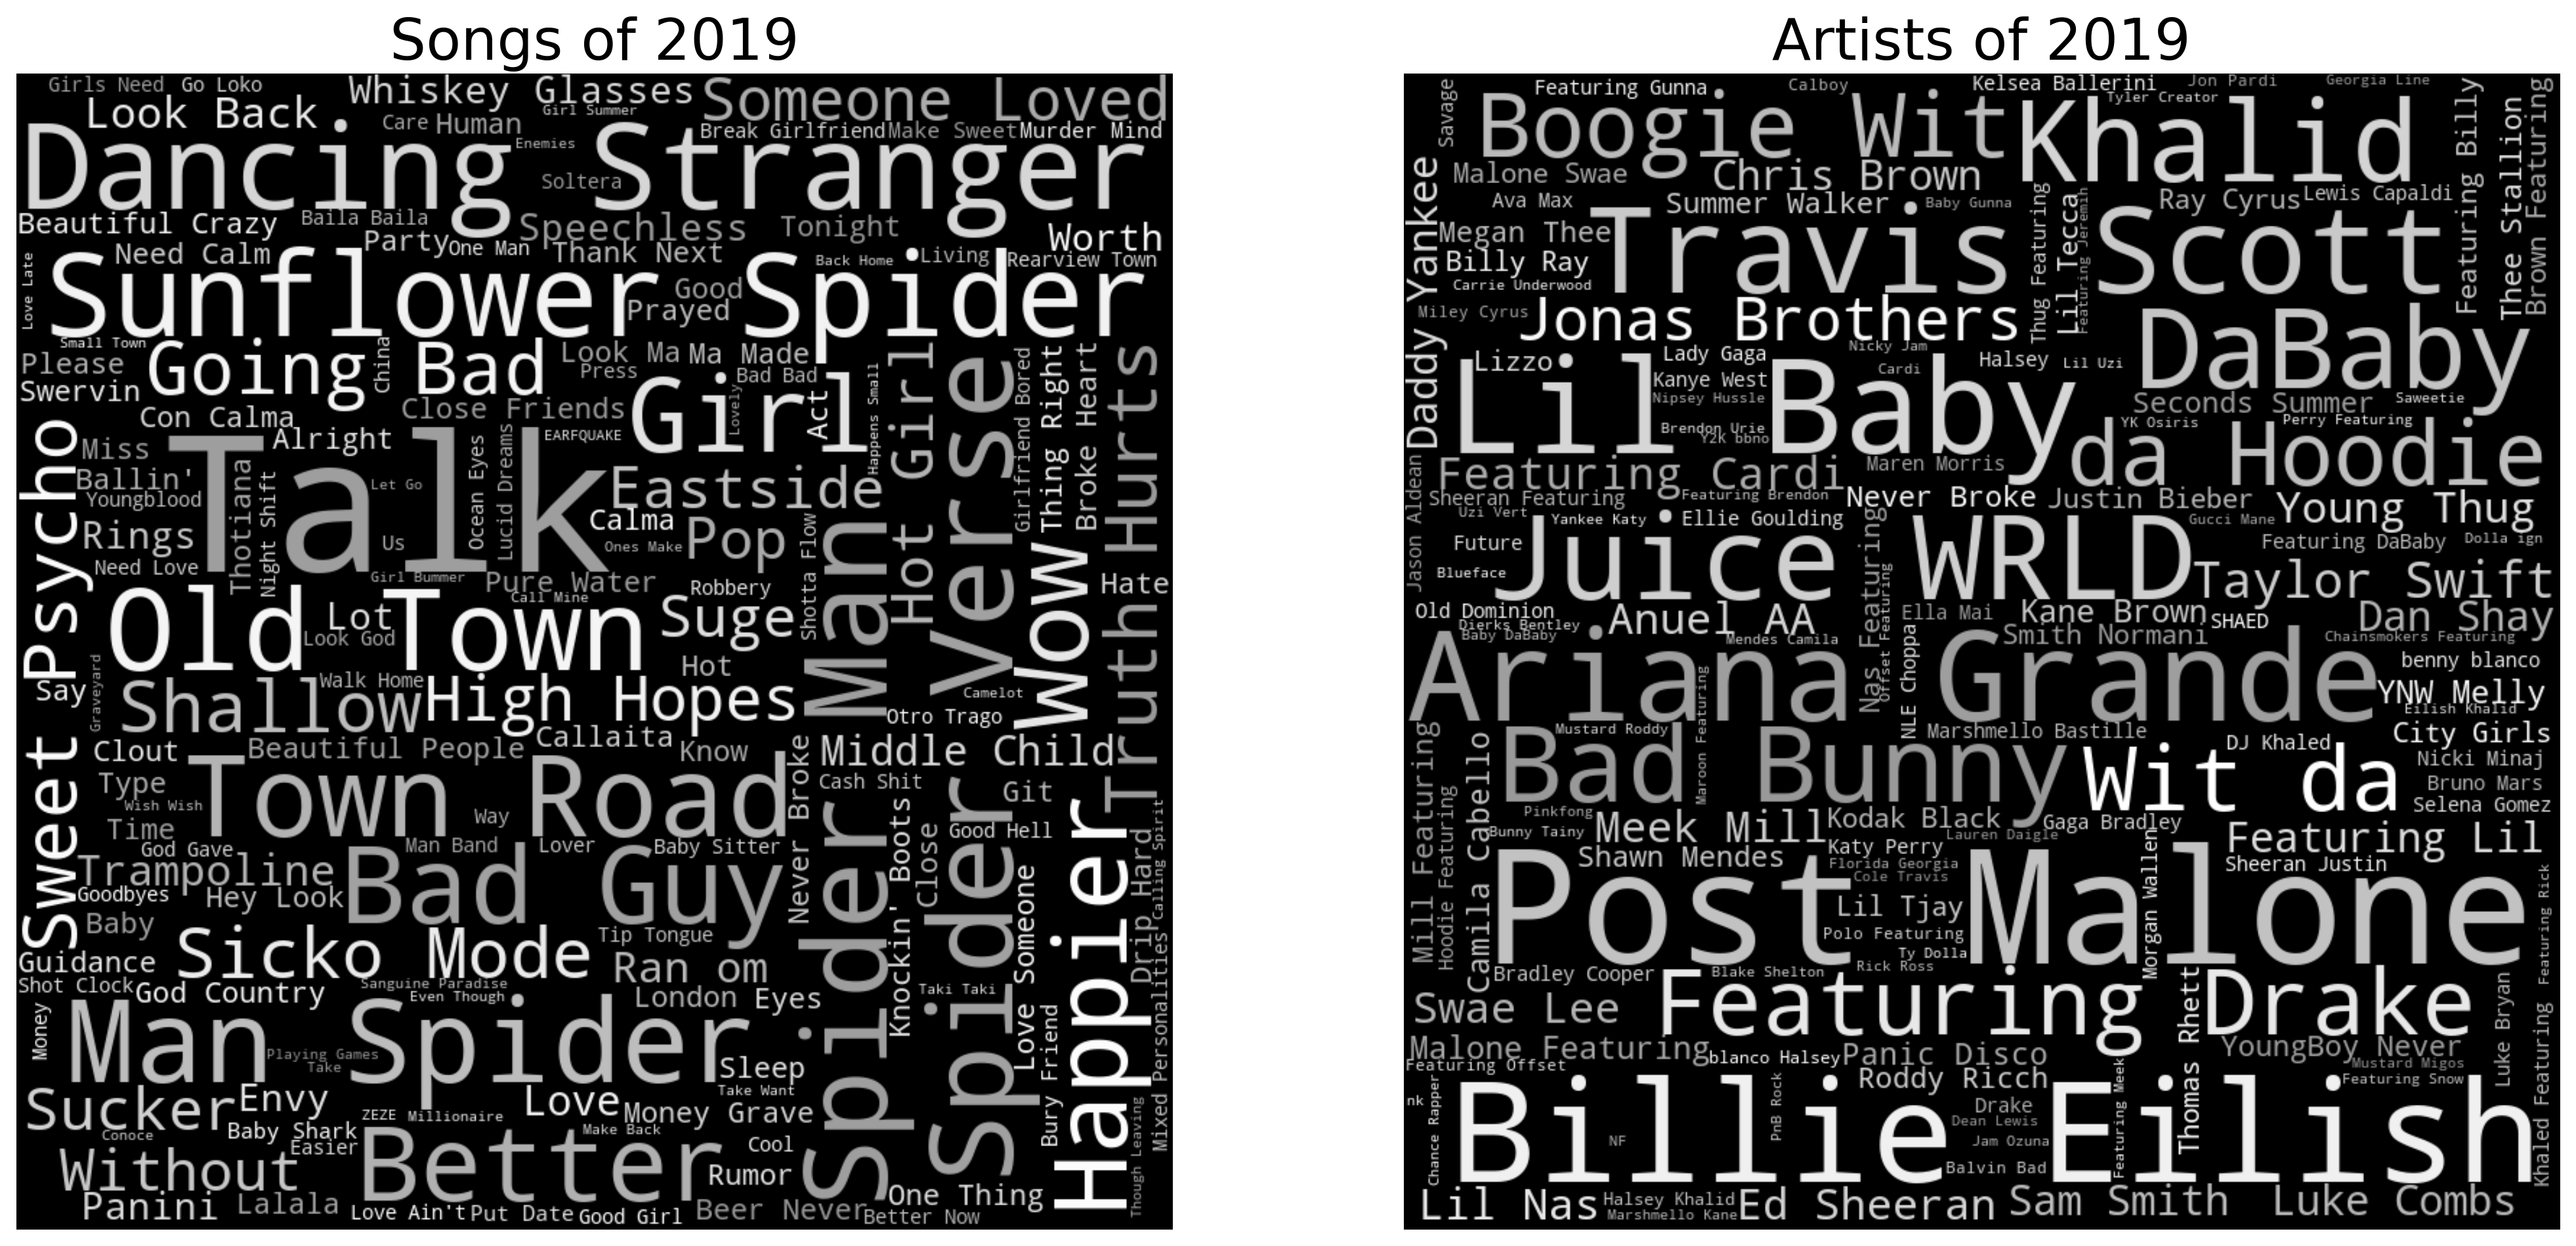

In [17]:
song_string = " ".join(df_songs['Song'].tolist())
artist_string = " ".join(df_songs['Artist'].tolist())
word_cloud(song_string, artist_string); 

Observing the word-cloud, it seems that Post Malone and Swae Lee's "Sunflower", which became the soundtrack of the animated film <em>Spider-Man: Into the Spider-Verse</em>, was a huge hit in 2019. Furthermore, song artists like Post Malone, Billie Eilish, Ariana Grande and Travis Scott seemed to have a good year in 2019. 

To have a more quantitative approach in these observations, the `"The Chart Dwellers": Who stayed the longest in the 2019 Billboard Hot 100?` bar graph shows the top 10 hit songs which stayed the longest time in 2019.

## 4.2 "The Chart Dwellers": Who stayed the longest in the 2019 Billboard Hot 100?

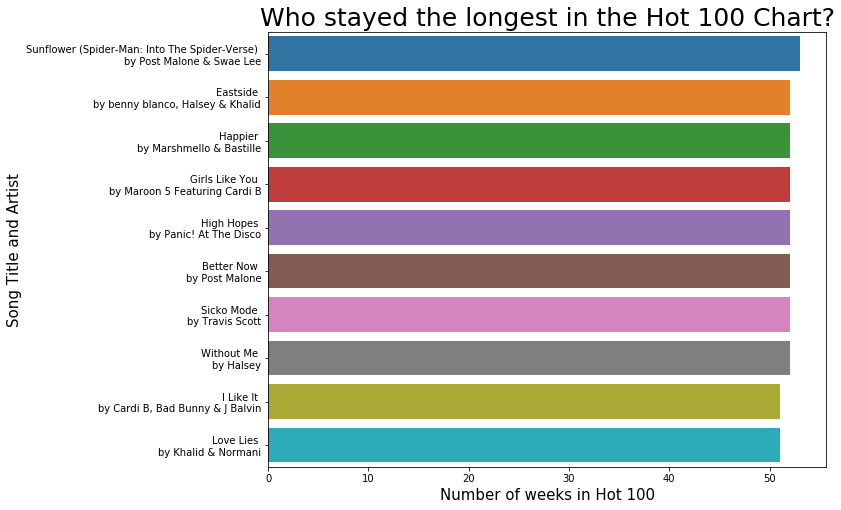

In [18]:
max_weeks = (df_songs.groupby(['Song','Artist'])['Weeks on Chart']
                     .max().sort_values(ascending=False).reset_index())
max_weeks['song_artist'] = max_weeks['Song'] + ' \nby ' + max_weeks['Artist']
max_weeks[:10]

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x="Weeks on Chart", y="song_artist", data=max_weeks[:10], ax=ax);
ax.set_title("Who stayed the longest in the Hot 100 Chart?", fontsize=25)
ax.set_xlabel("Number of weeks in Hot 100", fontsize=15)
ax.set_ylabel("Song Title and Artist", fontsize=15)
plt.show();
plt.close('all')

It turns out that these top 10 songs stayed in the US Billboard Hot 100 chart for roughly the entire 2019. Given these findings, it would be interesting to __find out and compare the musicalities of these Hot 100 songs__. 

In this study, we define `musicality` as __the quality of the music based on the audio features of each song__ that we collected from Spotify API.

## 4.3. The Sound of Music in 2019

In this section, we explore the musicality of the songs that made into the US Billboard Hot 100 list in 2019.

__MinMax Scaling:__ The measures of the audio features of each song vary slightly in terms of the range of possible values. Hence, the values were standardized based on the minimum and maximum values of each feature, and thus having values between 0 and 1. 

In [19]:
def minmax_scaler(df1):
    """Scale DataFrame values using the MinMax scaling."""
    
    df = df1.iloc[:, 6:].copy()
    cmax = df.max()
    cmin = df.min()
    
    for i in range(len(cmax)):
        df.iloc[:,i] = df.iloc[:,i].apply(lambda x : (x - cmin[i]) / 
                                                      (cmax[i] - cmin[i]))
    df1.iloc[:, 6:] = df
    return df1

In [20]:
# Idea of code taken from https://python-graph-gallery.com/392-use-faceting-for-radar-chart/`
def make_spider(df, row, title, color):
    """Return spider plot."""
    
    # Count number of features to include.
    categories = list(df)[1:]
    N = len(categories)

    # Calculate angle measurement of each axis in the plot.
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot.
    ax = plt.subplot(2, 2, row+1, polar=True)

    # Set initial axis pointing up.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=14)
    ax.set_rlabel_position(0)
    
    values = df.loc[row].drop("Weeks on Chart").values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=18, color=color, y=1.1, fontweight="bold")
    plt.tight_layout(pad=1.8)

In [21]:
df_scaled = minmax_scaler(df_songs)
# df_scaled = df_scaled.sort_values(by="Weeks on Chart", ascending=False)
# df_scaled1 = (df_scaled.groupby(['Song','Artist'])['Weeks on Chart']
#                      .max().sort_values(ascending=False).reset_index())
#df_scaled1.merge(df_scaled, on="Song", how="inner") #= df_scaled.unique()
# df_scaled.index = range(len(df_scaled))
df_scaled.head()

Date  Chart_Week  Rank  \
0  2019-01-05           1     1   
1  2019-01-05           1     2   
2  2019-01-05           1     3   
3  2019-01-05           1     4   
4  2019-01-05           1     5   

                                            Song                  Artist  \
0                                  Thank U, Next           Ariana Grande   
1                                     Without Me                  Halsey   
2                All I Want For Christmas Is You            Mariah Carey   
3                                     Sicko Mode            Travis Scott   
4  Sunflower (Spider-Man: Into The Spider-Verse)  Post Malone & Swae Lee   

   Weeks on Chart  danceability    energy       key  loudness  speechiness  \
0               8      0.646341  0.674509  0.090909  0.826720     0.076723   
1              12      0.693767  0.497261  0.545455  0.764016     0.085434   
2              30      0.616531  0.673434  1.000000  0.729563     0.093958   
3              21      0.804878  0.757224  0.727273  0.911744     0.366197   
4              10      0.704607  0.487593  0.181818  0.829377     0.041142   

   acousticness  instrumentalness  liveness   valence     tempo  
0      0.232849          0.000000  0.081032  0.399936  0.314216  
1      0.302035          0.000010  0.072657  0.528673  0.519423  
2      0.000303          0.000006  0.042214  0.753165  0.462840  
3      0.005074          0.000000  0.107062  0.436110  0.653290  
4      0.565552          0.000000  0.046288  0.932972  0.193844

__ALL SONGS:__ Taking into account the audio features of all songs that made it into the Hot 100 list in 2019, we calculated the average value of the scores in each feature. These measures give a bird's eye view of how the music scene in the US "sounded" in 2019. This is visualized by the `Overall Musicality of 2019 Billboard Hot 100 Songs`__radar chart__ given below.

In [22]:
all_songs = (pd.DataFrame(np.array(df_scaled.iloc[:, 6:].mean())
                          .reshape(1,10),
                          columns=df_scaled.iloc[:,6:].columns))
all_songs

danceability    energy       key  loudness  speechiness  acousticness  \
0      0.612454  0.647252  0.453881  0.806459     0.194599      0.226335   

   instrumentalness  liveness   valence     tempo  
0          0.007675  0.150268  0.493363  0.404521

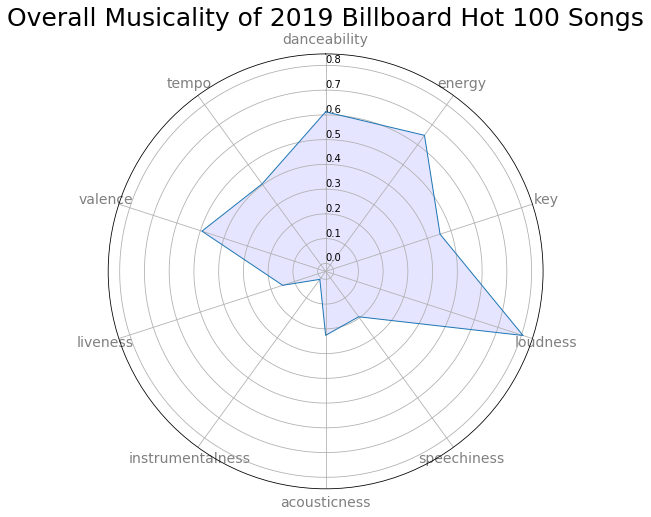

In [23]:
categories=list(all_songs)
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=all_songs.loc[0].values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / N * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, polar=True)
ax1 = plt.subplot(111, polar=True)
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=14)
 
# Draw ylabels
ax1.set_rlabel_position(0)
 
# Plot data
ax1.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax1.fill(angles, values, 'b', alpha=0.1)
ax1.set_title("Overall Musicality of 2019 Billboard Hot 100 Songs", 
              fontsize=25)
plt.show();
plt.close('all')

It turns out that most of the songs that made it into the Hot 100 list are __upbeat__ and __lively__ in nature. This is characterized by high degree of `loudness`, `danceability` and `energy`. Moreover, most of these songs have moderately high degree of `valence`. This suggests that most of the songs somehow have a __positive__ vibe in it. 

__SELECTED SONGS:__ Curious if the same pattern of musicality is observed in individual songs, we decided to pick four songs with highly different rank in terms of the number of weeks in 2019 that they made it into the Hot 100 list. Specifically, we chose the __top, 19th, 36th and bottom songs__ in terms of the number of weeks in 2019 that the song stayed in the Hot 100 list. 

In [24]:
by_weeks = (df_scaled.groupby(['Weeks on Chart', 'Song'])[['danceability', 'energy', 
                                                'key', 'loudness',
                                                'speechiness','acousticness', 
                                                'instrumentalness', 
                                                'liveness', 'valence', 
                                                'tempo']].mean()
                                                .reset_index()
                                                .sort_values(by='Weeks on'
                                                             ' Chart',
                                                             ascending=False))

by_weeks.index = range(len(by_weeks))
rows = [0, 18, 35, 52]
df = by_weeks.loc[rows]
df.index = range(len(df))
hits = [" by ".join(tuple(x)) for x in df_scaled
        .sort_values(by="Weeks on Chart", ascending=False)
        .reset_index(drop=True).iloc[rows, 3:5].to_numpy()]
df.head()

Weeks on Chart                                           Song  \
0              53  Sunflower (Spider-Man: Into The Spider-Verse)   
1              51                                     Without Me   
2              49                                        Happier   
3              48                                        Tequila   

   danceability    energy       key  loudness  speechiness  acousticness  \
0      0.704607  0.487593  0.181818  0.829377     0.041142      0.565552   
1      0.693767  0.497261  0.545455  0.764016     0.085434      0.302035   
2      0.605691  0.823826  0.454545  0.954477     0.038547      0.194186   
3      0.337398  0.597164  1.000000  0.822425     0.006857      0.031599   

   instrumentalness  liveness   valence     tempo  
0           0.00000  0.046288  0.932972  0.193844  
1           0.00001  0.072657  0.528673  0.519423  
2           0.00000  0.155727  0.675497  0.265157  
3           0.00000  0.116116  0.487179  0.166354

In [25]:
hits = df.pop("Song").tolist()

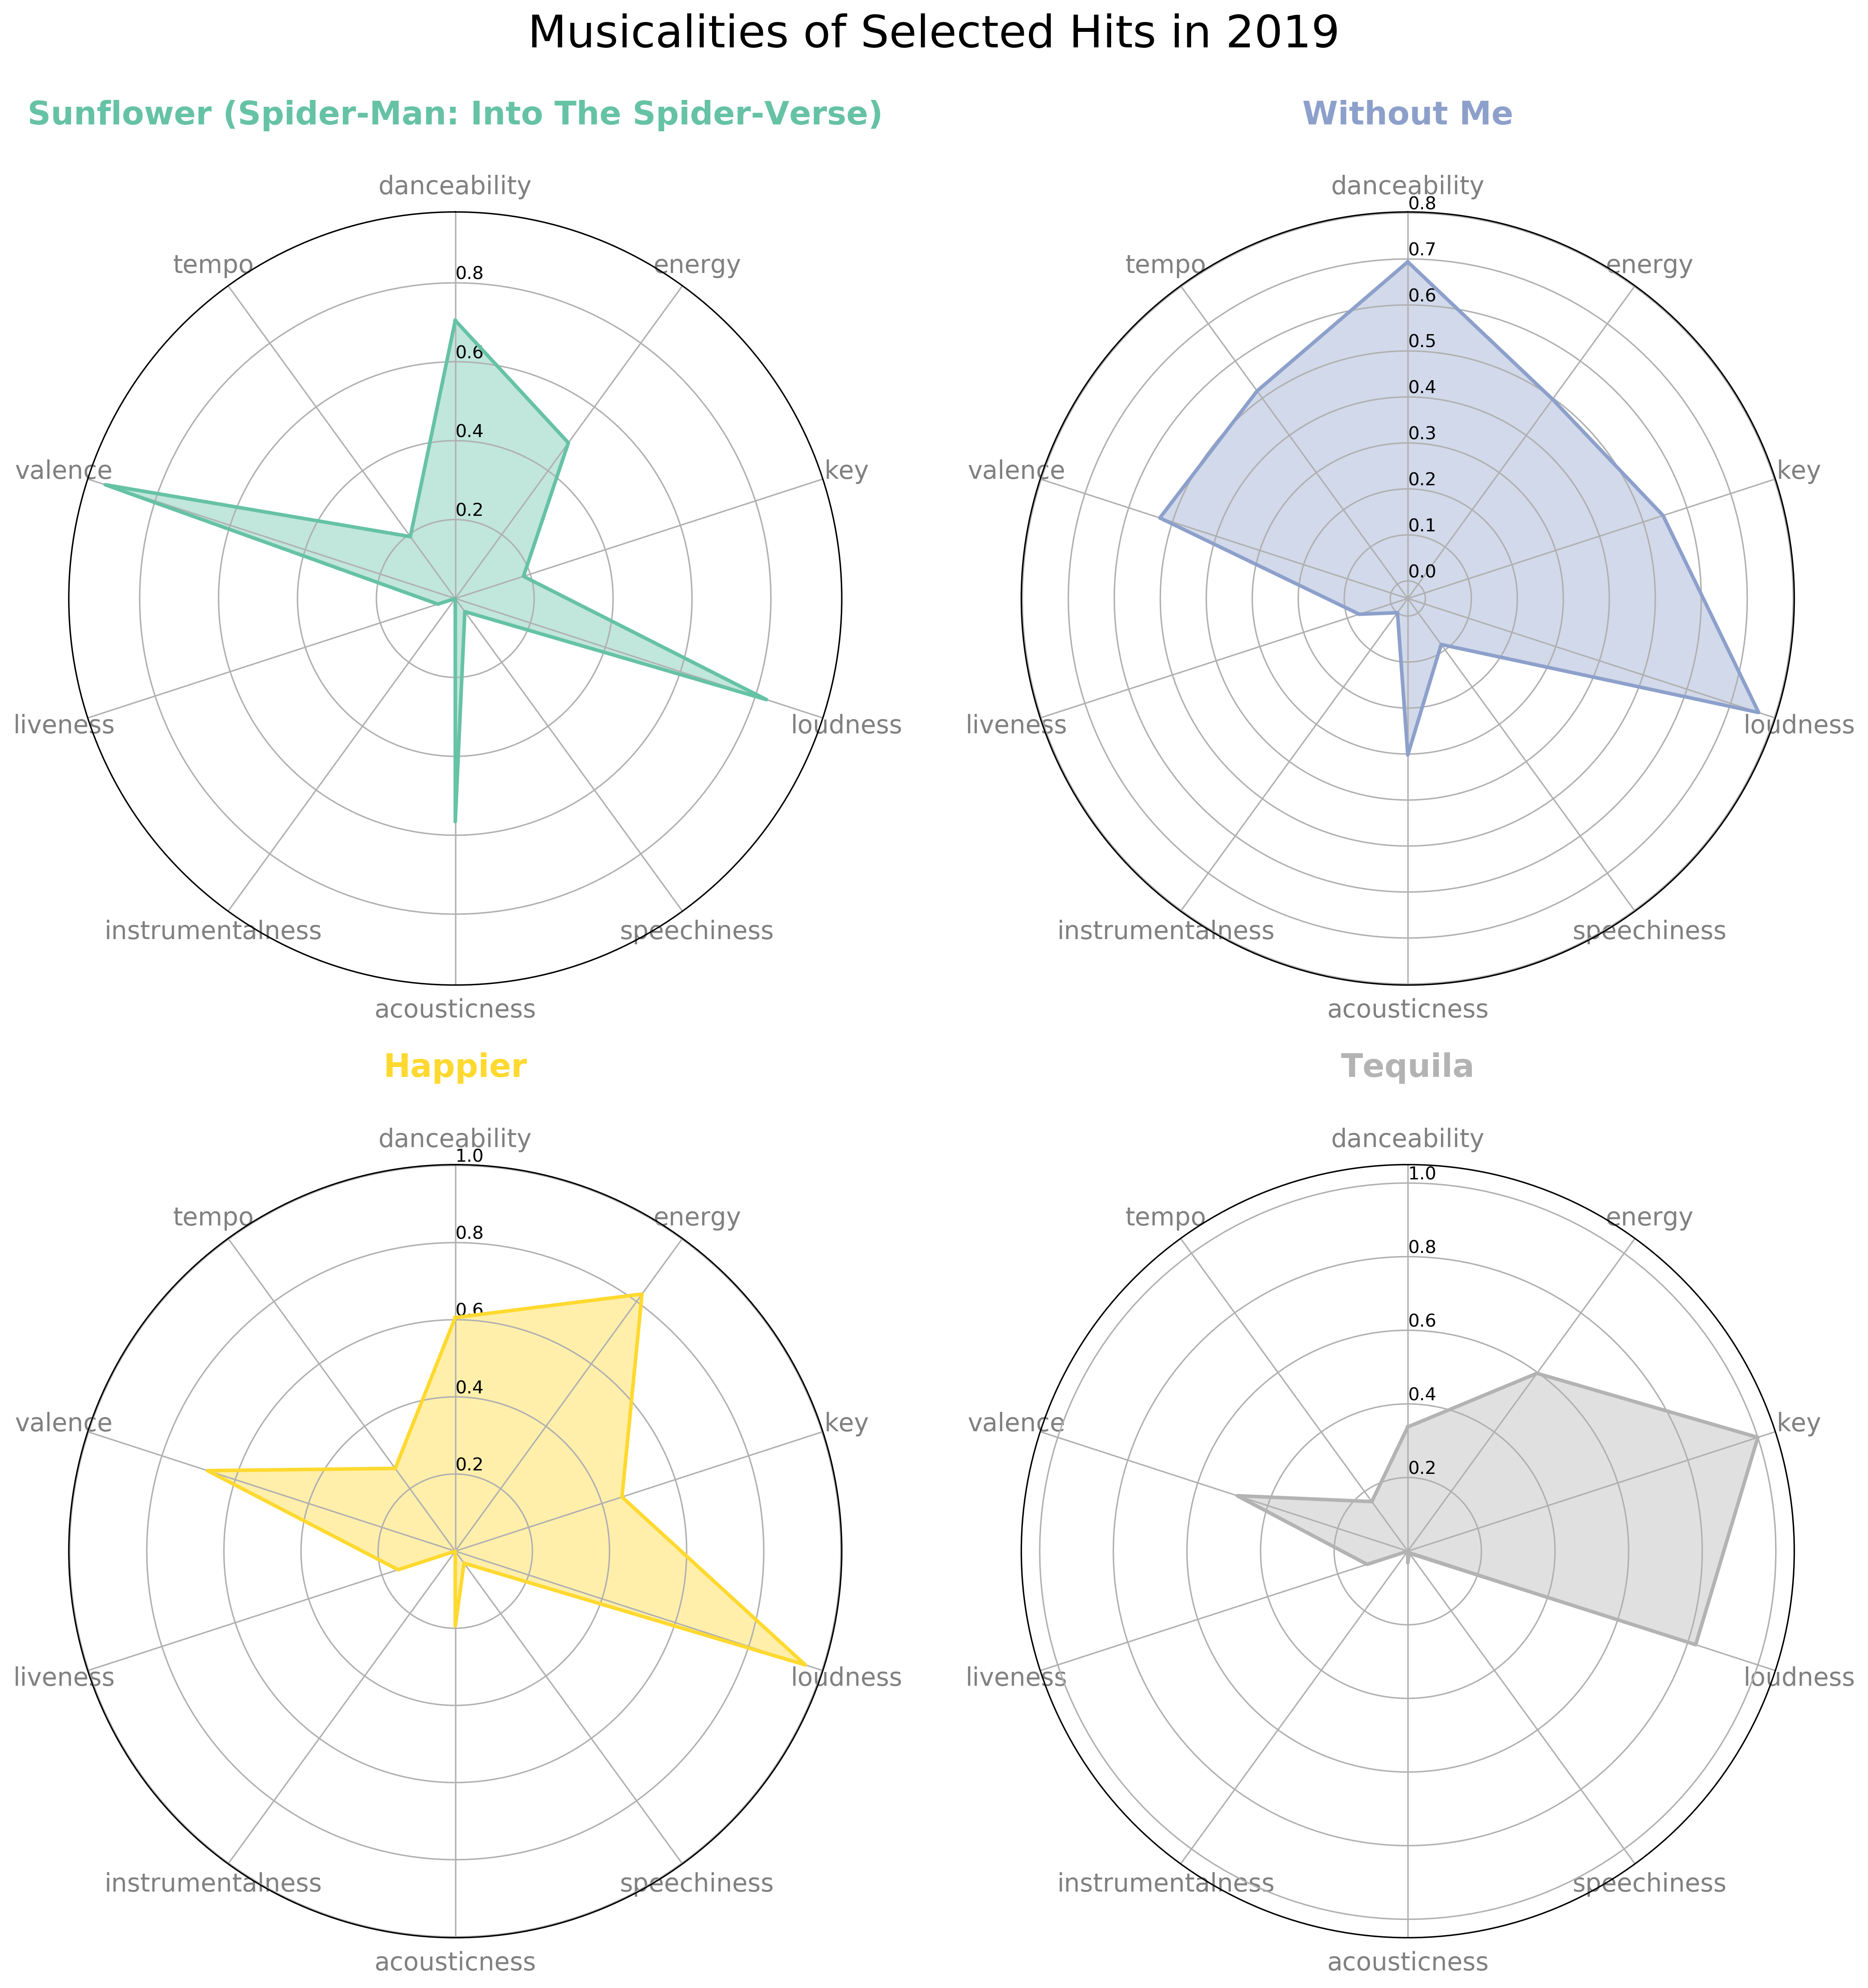

In [26]:
plt.figure(figsize=(15, 15), dpi=300)
plt.suptitle("Musicalities of Selected Hits in 2019", fontsize=25, y=1.028)
my_palette = plt.cm.get_cmap("Set2", len(df.index))
for row, hit in zip(range(len(df)), hits):
    make_spider(df, row=row, title=hit, color=my_palette(row))
plt.show();
plt.close('all')

The four ranks chosen in the dataset arranged according to the number of weeks in the US Billboard Hot 100 list are actually the boundaries if the data set is divided into 3 parts - the two 'slicers' in the middle and the extreme ranks. As shown in the `Musicalities of Selected Hits in 2019` radar chart, among the four songs selected,  it can be seen that they have highly different musicalities. However, it can be observed that all selected songs have high `loudness` score and low `speechiness` scores. This means that these songs tend to be loud but contains less spoken words. Also, notice that the `danceability` really varies by song but somehow leans of the moderately higher score. This means that most of the songs here tend to  have a danceable tune which can also be observed in the `energy` scores which tend to be moderate to high. It is worth noting that if you look at the big picture, the ones with danceable and loud music tend to stay longer in the Hot 100 list. 

# 5. Conclusion and Recommendation

Overall, our analyses suggest that 2019 was a year of fun, loud and positive music for the US Billboard Hot 100 charts. Visually, this is evident in the `Overall Musicality of 2019 Billboard Hot 100 Songs` radar chart that, in average, the songs that made it to the 2019 US Billboard Hot 100 list tend to have relatively high scores in `danceability`, `energy`, `loudness` and `valence`. As a recommendation, if you want to make new music and take a chance in grabbing a spot in the US Billboard Hot 100 list, perhaps it's a good jumpstart to consider composing loud songs that tend to have a danceable, energetic and positve vibe. 